# Run meta-analyses on 21 pain studies
Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [1]:
%matplotlib inline
import json
import numpy as np
from glob import glob
from os.path import basename, join, dirname, isfile
import urllib.request
import os

import pandas as pd
import nibabel as nib
from scipy.stats import t
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm)

/home/james/.conda/envs/nimare_dev/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/duecredit-0.6.4-py3.7.egg/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/duecredit-0.6.4-py3.7.egg/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/nipype-1.1.7-py3.7.egg/nipype/interfaces/base/traits_extension.py:28: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.a

In [ ]:
url = "https://raw.githubusercontent.com/tsalo/NiMARE/coco2019/download_test_data.py"
u = urllib.request.urlopen(url)
data = u.read()
u.close()

# write python to file
with open("download_test_data.py", "wb") as f:
    f.write(data)

# download the requisite data
from download_test_data import download_dataset
download_dataset()

In [2]:
dset_file = join(dirname(nimare.__file__), 'tests', 'data', 'nidm_pain_dset.json')
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
db = nimare.dataset.Database(dset_file)
dset = db.get_dataset()

mask_img = dset.mask

logp_thresh = -np.log(.05)

## Define functions for querying set of NIDM-Results packs

In [3]:
def _get_file(cdict, t):
    """Return the file associated with a given data type within a
    folder if it exists. Otherwise, returns an empty list.
    """
    temp = ''
    if t == 'con':
        temp = cdict['images'].get('con')
    elif t == 'se':
        temp = cdict['images'].get('se')
    elif t == 't':
        temp = cdict['images'].get('t')
    elif t == 'z':
        temp = cdict['images'].get('z')
    elif t == 'n':
        temp = cdict.get('sample_sizes', [])
        if temp:
            temp = np.mean(temp)
    else:
        raise Exception('Input type "{0}" not recognized.'.format(t))

    return temp


def get_files(ddict, types):
    """Returns a list of files associated with a given data type 
    from a set of subfolders within a directory. Allows for
    multiple data types and only returns a set of files from folders
    with all of the requested types.
    """
    all_files = []
    for study in ddict.keys():
        files = []
        cdict = ddict[study]['contrasts']['1']
        for t in types:
            temp = _get_file(cdict, t)
            if temp:
                files.append(temp)
            
        if len(files) == len(types):
            all_files.append(files)
    all_files = list(map(list, zip(*all_files)))
    return all_files

## Get z-maps

In [4]:
files = get_files(dset_dict, ['z'])
z_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in files[0]]
z_data = apply_mask(z_imgs, mask_img)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Fisher's

In [ ]:
%%time
result = fishers(z_data, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Stouffer's

### Fixed-effects inference

In [ ]:
%%time
result = stouffers(z_data, mask_img, inference='ffx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with theoretical null distribution

In [ ]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with empirical null distribution

In [ ]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='empirical', n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get z-maps + sample sizes

In [ ]:
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(z_data.shape[0]))

## Weighted Stouffer's

In [ ]:
%%time
result = weighted_stouffers(z_data, sample_sizes, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps + contrast standard error maps + sample sizes

In [ ]:
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in con_files]
se_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(con_data.shape[0]))

## FFX GLM

In [ ]:
%%time
result = ffx_glm(con_data, se_data, sample_sizes, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps

In [ ]:
con_files = get_files(dset_dict, ['con'])
con_files = con_files[0]
con_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in con_files]
con_data = apply_mask(con_imgs, mask_img)
print('{0} studies found.'.format(con_data.shape[0]))

## RFX GLM

### Theoretical null distribution

In [ ]:
%%time
result = rfx_glm(con_data, mask_img, null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Empirical null distribution

In [ ]:
%%time
result = rfx_glm(con_data, mask_img, null='empirical', n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## MKDA

### Density analysis

/home/james/.conda/envs/nimare_dev/lib/python3.7/site-packages/scipy-1.2.0-py3.7-linux-x86_64.egg/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 2.88 s, sys: 365 ms, total: 3.25 s
Wall time: 9.57 s


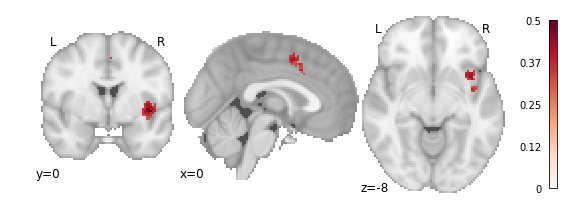

In [5]:
%%time
mkda = nimare.meta.cbma.MKDADensity(dset, kernel__r=10)
mkda.fit(n_iters=10, ids=dset.ids)
plot_stat_map(mkda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FDR correction

In [ ]:
%%time
mkda2 = nimare.meta.cbma.MKDAChi2(dset, kernel__r=10)
mkda2.fit(corr='FDR', ids=dset.ids, ids2=dset.ids)
plot_stat_map(mkda2.results.images['pAgF_z_FDR_05'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FWE correction

In [ ]:
%%time
mkda3 = nimare.meta.cbma.MKDAChi2(dset, ids=dset.ids, ids2=dset.ids, kernel__r=10)
mkda3.fit(corr='FWE', n_iters=10)
plot_stat_map(mkda3.results.images['pAgF_z_FWE_05'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## KDA

In [ ]:
%%time
kda = nimare.meta.cbma.KDA(dset, kernel__r=10)
kda.fit(n_iters=10, ids=dset.ids)
plot_stat_map(kda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## ALE

CPU times: user 5.55 s, sys: 376 ms, total: 5.93 s
Wall time: 11.5 s


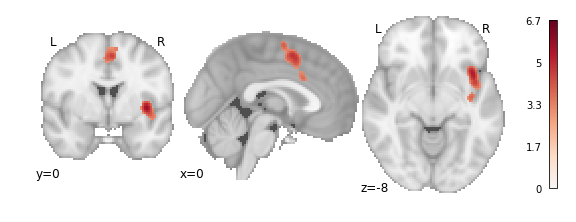

In [6]:
%%time
ale = nimare.meta.cbma.ALE(dset, ids=dset.ids)
ale.fit(n_iters=10, ids=dset.ids)
plot_stat_map(ale.results.images['cfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## SCALE

In [ ]:
%%time
ijk = np.vstack(np.where(dset.mask.get_data())).T
scale = nimare.meta.cbma.SCALE(dset, ids=dset.ids, ijk=ijk)
scale.fit(n_iters=10, ids=dset.ids)
plot_stat_map(scale.results.images['vthresh'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')